In [1]:
import cv2
import torch.hub
import os
import model
from PIL import Image
from torchvision import transforms
from grad_cam import BackPropagation
import time 
import matplotlib.pyplot as plt
from IPython import display
import threading
import vlc
from IPython.display import Audio
from enum import Enum

#import smbus
#import requests
#from twilio.rest import Client
#import urllib.request
#import json

# Alarm sound file
file = 'alarm.mp3'
# Sound player start
p = vlc.MediaPlayer("alarm.mp3")

timebasenoface= time.time()
timebasedrow= time.time()
timebasedis= time.time()
timerunnoface= time.time()
timerundrow= time.time()
timerundis= time.time()

face_cascade = cv2.CascadeClassifier('haar_models/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haar_models/haarcascade_eye.xml') 
#MyModel="BlinkModel.t7"
MyModel="model_10_64.t7"

shape = (24,24)
classes = [
    'Close',
    'Open',
]

eyess=[]
cface=0

imgMarkedup=0
imgDisplay=0

In [2]:
# reference https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_video_display/py_video_display.html
import numpy as np
import cv2
import paho.mqtt.client as mqtt 
import pickle
import time

#LOCAL_MQTT_HOST="mosquitto"
#LOCAL_MQTT_HOST="mosquitto-service"
LOCAL_MQTT_HOST="localhost"
LOCAL_MQTT_PORT=1883
LOCAL_MQTT_TOPIC="face_detector_topic"

# Create callback functions
def on_connect_local(client, userdata, flags, rc):
    print("Connected to local broker with rc: " + str(rc))

def on_publish_local(client, userdata, result):
    print("Data publlished")

# Create mqtt client
local_mqttclient = mqtt.Client()
local_mqttclient.on_connect = on_connect_local
local_mqttclient.on_publish = on_publish_local
local_mqttclient.connect(LOCAL_MQTT_HOST, LOCAL_MQTT_PORT, 60)

0

In [3]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: MIT-0
!pip3 install AWSIoTPythonSDK
import time as t
import json
import AWSIoTPythonSDK.MQTTLib as AWSIoTPyMQTT

# Define ENDPOINT, CLIENT_ID, PATH_TO_CERTIFICATE, PATH_TO_PRIVATE_KEY, PATH_TO_AMAZON_ROOT_CA_1, MESSAGE, TOPIC, and RANGE
ENDPOINT = "a2o3601o47s8jg-ats.iot.us-west-2.amazonaws.com"
CLIENT_ID = "testDevice"
PATH_TO_CERTIFICATE = ""
PATH_TO_PRIVATE_KEY = ""
PATH_TO_AMAZON_ROOT_CA_1 = ""
MESSAGE = "Hello World"
TOPIC = "device/1/data"
DEVICEID = 1
USERID="sri"
LAT= 37.7893780
LONG= -121.8949266
RANGE = 1

def pushToAWSIOT(msg):
    myAWSIoTMQTTClient = AWSIoTPyMQTT.AWSIoTMQTTClient(CLIENT_ID)
    myAWSIoTMQTTClient.configureEndpoint(ENDPOINT, 8883)
    myAWSIoTMQTTClient.configureCredentials(PATH_TO_AMAZON_ROOT_CA_1, PATH_TO_PRIVATE_KEY, PATH_TO_CERTIFICATE)

    myAWSIoTMQTTClient.connect()
    print('Begin Publish')
    for i in range (RANGE):
        data = "{} [{}]".format(msg, i+1)
        message = {"deviceID" : DEVICEID, "userID" : USERID, "Lat": LAT, "Long": LONG, "message" : data}
        myAWSIoTMQTTClient.publish(TOPIC, json.dumps(message), 1) 
        print("Published: '" + json.dumps(message) + "' to the topic" + "' '")
        t.sleep(0.1)
    print('Publish End')
    myAWSIoTMQTTClient.disconnect()

In [4]:
def preprocess(cap_image):
    global cface
    transform_test = transforms.Compose([
        transforms.ToTensor()
    ])
    gray = cv2.cvtColor(cap_image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 3)
    if len(faces) == 0:
        ...
    else:
        cface=1
        (x, y, w, h) = faces[0]
        cv2.rectangle(cap_image,(x,y),(x+w,y+h),(255,255,0),2)
        roi_gray = gray[y:y + h, x:x + w]
        roi_color = cap_image[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray, scaleFactor=1.3, minNeighbors=20) 
        i=0
        for (ex,ey,ew,eh) in eyes:
            (x, y, w, h) = eyes[i]
            cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
            eye = roi_color[y:y + h, x:x + w]
            eye = cv2.resize(eye, shape)
            eyess.append([transform_test(Image.fromarray(eye).convert('L')), eye, cv2.resize(roi_color, (48,48))])
            i=i+1
    cv2.imwrite('temp-images/img-markedup.jpg',cap_image)    

def eye_status(eye, net):
    img = torch.stack([eye])
    bp = BackPropagation(model=net)
    probs, ids = bp.forward(img)
    actual_status = ids[:, 0]
    prob = probs.data[:, 0]
    if actual_status == 0:
        prob = probs.data[:,1]

    #print(name,classes[actual_status.data], probs.data[:,0] * 100)
    return classes[actual_status.data]

def func(cap_image,modl):
    drow(cap_image=cap_image,model_name=modl)

def drow(cap_image, model_name):
    global eyess
    global cface
    global driverstate
    global timebasedrow
    global timebasedis
    global timerundrow
    global timerundis
    net = model.Model(num_classes=len(classes))
    checkpoint = torch.load(os.path.join('model', model_name), map_location=torch.device('cpu'))
    net.load_state_dict(checkpoint['net'])
    net.eval()
    
    status = ""
    msg = ""
    preprocess(cap_image)
    if cface==0:
        msg = f'Face not detected.'
        timebasedrow= time.time()
        timebasedis= time.time()
        timerundrow= time.time()
        timerundis= time.time()
    elif(len(eyess)!=0):
        eye, eye_raw, face = eyess[0]
        timebasedrow= time.time()
        timerundrow= time.time()
        status = eye_status(eye, net)
        if(status == "Close"):
            msg = f'Face detected, eyes closed.'
            timerundis= time.time()
            if((timerundis-timebasedis)>1.5):
                msg = f'Distracted - eyes closed for {timerundis-timebasedis:.2f}s.'
                if(not(p.is_playing())):
                    p.play()
        else:
            msg = f'Face detected, eyes open.'
            local_mqttclient.publish(LOCAL_MQTT_TOPIC, msg, qos=0, retain=False)
            pushToAWSIOT(msg)
    
            p.stop()        
    else:
        msg = f'Face detected, no eyes.'
        timerundrow= time.time()
        if((timerundrow-timebasedrow)>3):
            if(not(p.is_playing())):
                p.play()
            msg = f'Distracted - no eyes for {timerundrow-timebasedrow:.2f}s.'
    image = cv2.imread("temp-images/img-markedup.jpg")
    if image.size != 0:
        image = cv2.putText(image, msg, (50, 75), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 2, cv2.LINE_AA)
        cv2.imwrite('temp-images/display.jpg',image)
        
        # Encode and publish to mqtt->  EC2 -> S3
        ret, png = cv2.imencode('.png', image) 
        message1 = pickle.dumps(png)
        local_mqttclient.publish(LOCAL_MQTT_TOPIC, message1, qos=0, retain=False)
        pushToAWSIOT(msg)
    

In [5]:
def main():
    while 1:
        global eyess
        global cface    
        eyess=[]
        cface=0
        ret, cap_img = cap.read()
        if ret == True:
            func(cap_img, MyModel)

def disp():
    while 1:
        try:
            img=plt.imread('temp-images/display.jpg')
            plt.imshow(img)
            display.clear_output(wait=True)
            display.display(plt.gcf())
        except:
            ...

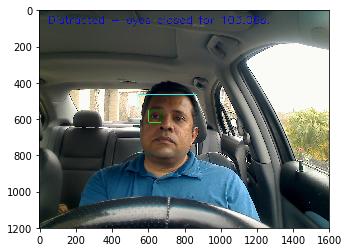

In [6]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_BUFFERSIZE, 1) # added
#cv2.waitKey(1) # added
timebasedrow= time.time()
timebasedis= time.time()
timerundrow= time.time()
timerundis= time.time()

d = threading.Thread(target=disp, name='disp')
m = threading.Thread(target=main, name='main')

m.start()
d.start()